In [1]:
import findspark
findspark.init()

# create spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("my app").master("local").getOrCreate()

# get context from the session
sc = spark.sparkContext

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import time

# Misc

In [3]:
def create_dataset(N, D=2, minval=[0, 0], maxval=[1, 1]):
    """
    D차원 벡터 N개를 생성
    """

    dataset = np.zeros((N, D+1))
    
    # gen IDs
    dataset[:, 0] = np.arange(N, dtype='int')
    
    # gen values
    for i in range(D):
        vec = np.random.rand(N) * (maxval[i] - minval[i]) + minval[i]
        dataset[:, i+1] = vec

    return dataset

In [4]:
def compute_distance(p1, p2):
    """
    주어진 2개 데이터포인트에 대해 거리 계산
    """
    
    distance = np.sqrt(np.sum((p1[1:] - p2[1:])**2))
    return distance

# Map / Reduce Functions

In [5]:
def distribute(t):
    global M
    gid = hash(str(t[0])) % M
    for i in range(M):
        if i < gid:
            yield ((i, gid), (gid, t))
        else:
            yield ((gid, i), (gid, t))

In [6]:
def join(t):
    global thres
    key, values = t
    if key[0] == key[1]:
        l = list(values)
        for i,v1 in enumerate(l):
            for j,v2 in enumerate(l):
                if i<j and compute_distance(v1[1], v2[1]) < thres:
                    yield (v1[1][0], v2[1][0]) if v1[1][0]<v2[1][0] else (v2[1][0], v1[1][0])
    else:
        l = list(values)
        l1 = list()
        l2 = list()
        for t in values:
            if key[0] == t[0]:
                l1.append(t[1])
            else:
                l2.append(t[1])
        for i,p1 in enumerate(l1):
            for j,p2 in enumerate(l2):
                if compute_distance(p1, p2) < thres:
                    yield (p1[0], p2[0]) if p1[0]<p2[0] else (p2[0], p1[0])
                        

# Test

In [7]:
M = 5
N = 1000
thres = 0.01

In [8]:
local = create_dataset(N)

In [9]:
rdd = sc.parallelize(local).flatMap(distribute).groupByKey().flatMap(join)

In [10]:
res1 = sorted(rdd.collect())

In [11]:
res2 = list()
for i,p1 in enumerate(local):
    for j,p2 in enumerate(local):
        if i<j and compute_distance(p1, p2) < thres:
            if p1[0]<p2[0]:
                res2.append((p1[0], p2[0]))
            else:
                res2.append((p2[0], p1[0]))

In [12]:
assert res1 == res2, "fail"

# Evaluation

In [15]:
Ns = [200, 400, 800, 1600]
Ms = [1, 2, 4, 8]
thres = 0.01

In [20]:
execution_time = list()
for N in Ns:
    ts = list()
    local = create_dataset(N)
    for M in Ms:
        start_time = time.time()
        sc.parallelize(local).flatMap(distribute).groupByKey().flatMap(join).count()
        ts.append(time.time() - start_time)
    execution_time.append(ts)

In [33]:
execution_time = np.array(execution_time).T.tolist()

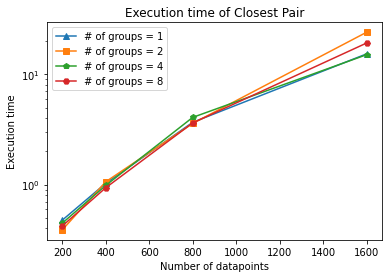

In [36]:
markers=['^', 's', 'p', 'H']
labels = [ '# of groups = {}'.format(n) for n in Ms ]
for ts, m, lb in zip(execution_time, markers, labels):
    plt.plot(Ns, ts, linestyle='-', marker=m, label=lb)
plt.xlabel("Number of datapoints")
plt.ylabel("Execution time")
plt.title("Execution time of Closest Pair")
plt.yscale('log')
plt.legend(loc='best')
plt.show()

In [38]:
execution_time = np.array(execution_time).T.tolist()

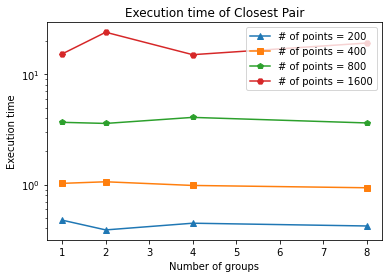

In [41]:
markers=['^', 's', 'p', 'H']
labels = [ '# of points = {}'.format(n) for n in Ns ]
for ts, m, lb in zip(execution_time, markers, labels):
    plt.plot(Ms, ts, linestyle='-', marker=m, label=lb)
plt.xlabel("Number of groups")
plt.ylabel("Execution time")
plt.title("Execution time of Closest Pair")
plt.yscale('log')

plt.legend(loc='best')
plt.show()